title: "Anomaly detection from realtime ECG Data"    
author: "Raikibul HASAN"    
date: "2023-01-03"    

In [11]:
#Import all the libraries
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import iqr
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
#import plotly.graph_objs as go
#import plotly.express as px
from scipy.signal import medfilt, butter, filtfilt
import pywt
from sklearn.model_selection import train_test_split
import scipy.signal
from keras.models import Sequential
from keras.layers import LSTM, Dense, Reshape
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score

In [2]:
#1 Load data
#os.chdir('../data') # set working directory to your file's location
dataset = '../data/data.csv'
df=pd.read_csv(dataset)
df.head()

,FileName,Rhythm,Beat,PatientAge,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
0,MUSE_20180113_171327_27000,AFIB,RBBB TWC,85,MALE,117,234,114,356,496,81,-27,19,208,265,386
1,MUSE_20180112_073319_29000,SB,TWC,59,FEMALE,52,52,92,432,401,76,42,8,215,261,431
2,MUSE_20180111_165520_97000,SA,NONE,20,FEMALE,67,67,82,382,403,88,20,11,224,265,415
3,MUSE_20180113_121940_44000,SB,NONE,66,MALE,53,53,96,456,427,34,3,9,219,267,447
4,MUSE_20180112_122850_57000,AF,STDD STTC,73,FEMALE,162,162,114,252,413,68,-40,26,228,285,354


In [3]:
# 2 - The number of rows and columns for each
print(f"Number of rows :{df.shape[0]} & columns: {df.shape[1]} in Diagnostics dataset")

Number of rows :10646 & columns: 16 in Diagnostics dataset


<h1> Feature Engineering</h1>

In [4]:
# 3
'''

 df.count() returns Series with number of non-NA/null observations. 
 And, 'idxmin' would give you column with most non-NA/null values.
 
'''
print(f" Columns: {df.count().idxmin()} has most missing value in app_test dataset")


 Columns: FileName has most missing value in app_test dataset


In [5]:
missing_value=df.isnull().sum().sort_values(ascending=False)
print(f"Columns name  with value which has highest Missing value in our dataset :\n{ missing_value.head(3)}")#print 3 as they have same number
missing_value

Columns name  with value which has highest Missing value in our dataset :
FileName    0
Rhythm      0
Beat        0
dtype: int64


FileName           0
Rhythm             0
Beat               0
PatientAge         0
Gender             0
VentricularRate    0
AtrialRate         0
QRSDuration        0
QTInterval         0
QTCorrected        0
RAxis              0
TAxis              0
QRSCount           0
QOnset             0
QOffset            0
TOffset            0
dtype: int64

In [6]:
numerical_columns = df.select_dtypes(include=['number']).columns
summary_stats = df[numerical_columns].describe()
print(summary_stats)

         PatientAge  VentricularRate   AtrialRate   QRSDuration    QTInterval  \
count  10646.000000     10646.000000  10646.00000  10646.000000  10646.000000   
mean      59.186831        84.136107     92.57787     90.989292    384.150855   
std       18.030019        34.455349     60.09394     17.479540     59.226289   
min        4.000000        34.000000      0.00000     18.000000    114.000000   
25%       49.000000        57.000000     57.00000     80.000000    344.000000   
50%       62.000000        73.000000     72.00000     88.000000    390.000000   
75%       72.000000       104.000000    106.00000     98.000000    426.000000   
max       98.000000       263.000000    535.00000    256.000000    736.000000   

        QTCorrected         RAxis         TAxis      QRSCount        QOnset  \
count  10646.000000  10646.000000  10646.000000  10646.000000  10646.000000   
mean     434.154048     39.620609     44.637704     13.839470    219.260567   
std       39.354182     41.212648

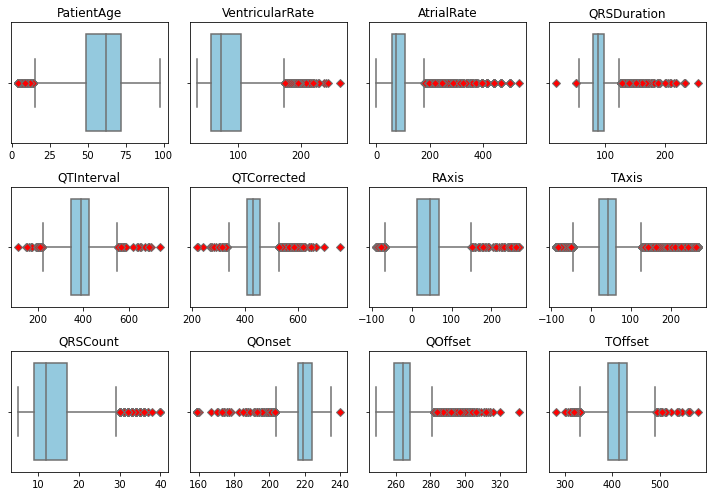

In [7]:
# Outlier detection
numerical_columns = df.select_dtypes(include=['number']).columns
num_rows = 3
num_cols = 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 7))

axes = axes.flatten()
for i, column in enumerate(numerical_columns):
    sns.boxplot(x=df[column], ax=axes[i], color='skyblue',whis=1.5, flierprops=dict(markerfacecolor='r', marker='D'))
    axes[i].set_title(f'{column}')
    axes[i].set_xlabel('')
plt.tight_layout()

# Show the plot
plt.show()


In [8]:
z_scores = zscore(df[numerical_columns])
abs_z_scores = abs(z_scores)

# Count outliers for each column
outlier_counts_per_column = (abs_z_scores > 3.5).sum(axis=0)

# Count the total number of outliers for each row
total_outliers_per_row = (abs_z_scores > 3).sum(axis=1)

print("Outliers per Column:")
print(outlier_counts_per_column)

print("\nTotal Outliers per Row:")
print(total_outliers_per_row)


Outliers per Column:
PatientAge           0
VentricularRate     52
AtrialRate         236
QRSDuration        133
QTInterval          18
QTCorrected         78
RAxis               54
TAxis              205
QRSCount            49
QOnset              52
QOffset            134
TOffset             14
dtype: int64

Total Outliers per Row:
0        0
1        0
2        0
3        0
4        0
        ..
10641    7
10642    3
10643    2
10644    0
10645    1
Length: 10646, dtype: int64


In [9]:
unique= df['Beat'].unique()
unique

array(['RBBB TWC', 'TWC', 'NONE', 'STDD STTC', 'LVHV', '1AVB', 'ABI LVHV',
       'STTC', 'RBBB', '1AVB TWO', 'LBBB LVHV PWC', 'AQW', 'APB', 'AVB',
       'TWC VPB', 'LVHV VPB', 'VPB', 'IDC LVHV', 'STDD TWC', 'LVQRSCL',
       'STTC VPB', 'ALS', 'RBBB STTC', 'LVHV TWC', 'LVHV STTC', 'ARS AVB',
       'IDC LVHV STTC', 'ALS TWC VPB', 'CCR', 'IDC MIFW MILW',
       'MIFW STDD TWC', '1AVB APB LVHV', 'LVQRSLL RBBB',
       '1AVB IVB LFBBB STTC', 'LVQRSLL', 'STDD STTC TWO', 'ALS STTC',
       'APB STTC', 'LVHV STDD STTC TWC', 'IVB STDD STTC TWC VPB',
       'IDC LFBBB', 'STDD STTC TWC', '1AVB LBBB', 'STTU TWC', 'VET',
       'IVB', 'ALS LVQRSLL STTC', 'APB LBBB', 'LVHV RBBB TWC',
       'AQW MIFW STDD STTU', 'LVHV RBBB', 'QTIE RBBB UW', 'TWC UW', 'ARS',
       '1AVB ALS TWC', 'AQW STDD STTC TWC', 'AVB TWC', 'LVQRSCL LVQRSLL',
       'LVHV TWC TWO', 'PWC STDD STTC TWC', 'CCR TWC', 'ERV LVHV',
       'IVB STTC', 'PRIE', 'STTU', 'ALS LVQRSCL', 'LBBB', '1AVB STTU',
       'ALS IVB LFBBB', 'IDC T

In [10]:
category_counts = df['Beat'].value_counts()
# Get the category with the highest count
#highest_count_category = category_counts.idxmax()

# Create a new column to store the converted categories
df['Target'] = 1

# Assign the highest count category to one category and "red" category to another category
df.loc[df['Beat'] == 'NONE', 'Target'] = 1

df

,FileName,Rhythm,Beat,PatientAge,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset,Target
0,MUSE_20180113_171327_27000,AFIB,RBBB TWC,85,MALE,117,234,114,356,496,81,-27,19,208,265,386,1
1,MUSE_20180112_073319_29000,SB,TWC,59,FEMALE,52,52,92,432,401,76,42,8,215,261,431,1
2,MUSE_20180111_165520_97000,SA,NONE,20,FEMALE,67,67,82,382,403,88,20,11,224,265,415,1
3,MUSE_20180113_121940_44000,SB,NONE,66,MALE,53,53,96,456,427,34,3,9,219,267,447,1
4,MUSE_20180112_122850_57000,AF,STDD STTC,73,FEMALE,162,162,114,252,413,68,-40,26,228,285,354,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10641,MUSE_20181222_204306_99000,SVT,NONE,80,FEMALE,196,73,168,284,513,258,244,32,177,261,319,1
10642,MUSE_20181222_204309_22000,SVT,NONE,81,FEMALE,162,81,162,294,482,110,-75,27,173,254,320,1
10643,MUSE_20181222_204310_31000,SVT,NONE,39,MALE,152,92,152,340,540,250,38,25,208,284,378,1
10644,MUSE_20181222_204312_58000,SVT,NONE,76,MALE,175,178,128,310,529,98,-83,29,205,269,360,1


In [178]:
df_one_hot = pd.concat([df, pd.get_dummies(df['Gender'], prefix='Gender')], axis=1).drop('Gender', axis=1)
df_one_hot['Gender_FEMALE'] = df_one_hot['Gender_FEMALE'].astype(int)
df_one_hot['Gender_MALE'] = df_one_hot['Gender_MALE'].astype(int)
df_one_hot.head()


,FileName,Rhythm,Beat,PatientAge,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset,Target,Gender_FEMALE,Gender_MALE
0,MUSE_20180113_171327_27000,AFIB,RBBB TWC,85,117,234,114,356,496,81,-27,19,208,265,386,1,0,1
1,MUSE_20180112_073319_29000,SB,TWC,59,52,52,92,432,401,76,42,8,215,261,431,1,1,0
2,MUSE_20180111_165520_97000,SA,NONE,20,67,67,82,382,403,88,20,11,224,265,415,0,1,0
3,MUSE_20180113_121940_44000,SB,NONE,66,53,53,96,456,427,34,3,9,219,267,447,0,0,1
4,MUSE_20180112_122850_57000,AF,STDD STTC,73,162,162,114,252,413,68,-40,26,228,285,354,1,1,0


In [179]:
label_encoder = LabelEncoder()
df_one_hot['Rhythm_encoded'] = label_encoder.fit_transform(df_one_hot['Rhythm'])
df_one_hot.head()

,FileName,Rhythm,Beat,PatientAge,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset,Target,Gender_FEMALE,Gender_MALE,Rhythm_encoded
0,MUSE_20180113_171327_27000,AFIB,RBBB TWC,85,117,234,114,356,496,81,-27,19,208,265,386,1,0,1,1
1,MUSE_20180112_073319_29000,SB,TWC,59,52,52,92,432,401,76,42,8,215,261,431,1,1,0,7
2,MUSE_20180111_165520_97000,SA,NONE,20,67,67,82,382,403,88,20,11,224,265,415,0,1,0,5
3,MUSE_20180113_121940_44000,SB,NONE,66,53,53,96,456,427,34,3,9,219,267,447,0,0,1,7
4,MUSE_20180112_122850_57000,AF,STDD STTC,73,162,162,114,252,413,68,-40,26,228,285,354,1,1,0,0


In [180]:
# Drop column of index using DataFrame.iloc[] and drop() methods.
df2 =df_one_hot.drop(df_one_hot.iloc[:, 0:3],axis = 1)
print(df2) 

       PatientAge  VentricularRate  AtrialRate  QRSDuration  QTInterval  \
0              85              117         234          114         356   
1              59               52          52           92         432   
2              20               67          67           82         382   
3              66               53          53           96         456   
4              73              162         162          114         252   
...           ...              ...         ...          ...         ...   
10641          80              196          73          168         284   
10642          81              162          81          162         294   
10643          39              152          92          152         340   
10644          76              175         178          128         310   
10645          75              117         104          140         312   

       QTCorrected  RAxis  TAxis  QRSCount  QOnset  QOffset  TOffset  Target  \
0              496 

In [181]:
## Your code here
df_org =df.copy()

In [182]:
scaler = MinMaxScaler()
df3 = scaler.fit_transform(df2)
df3 = pd.DataFrame(df3, columns=df2.columns)

In [183]:
from sklearn.ensemble import RandomForestClassifier
X = df2.drop('Target', axis=1)
y = df2['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

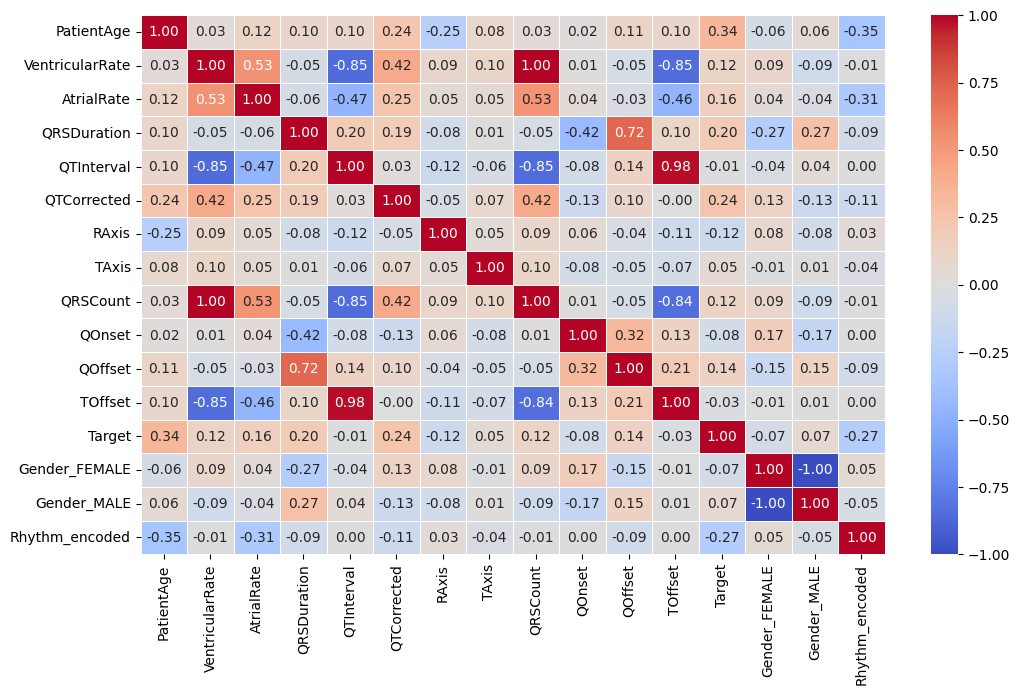

In [195]:
# correlation
numerical_variables = df2.select_dtypes(include='number')
correlation_matrix = numerical_variables.corr()
plt.figure(figsize=(12, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('')
plt.show()


In [185]:
corr_matrix = X_train.corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]
X_train = X_train.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)

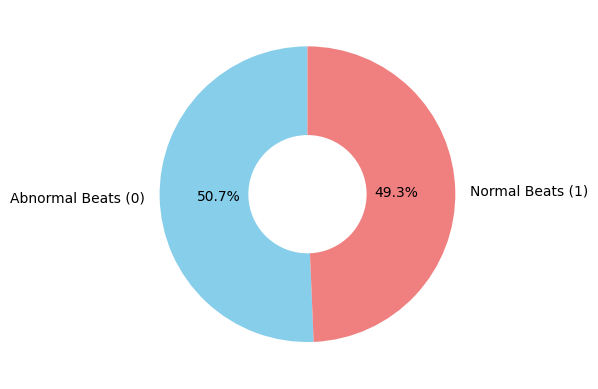

In [186]:
c = y_train.value_counts()
c.index = ['Abnormal Beats (0)' if idx == 0 else 'Normal Beats (1)' for idx in c.index]
custom_colors = ['skyblue', 'lightcoral']
fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
wedges, texts, autotexts = ax.pie(c, labels=c.index, autopct='%1.1f%%', colors=custom_colors, startangle=90, wedgeprops=dict(width=0.6))
ax.set_title('')
# Display the plot
plt.show()

In [187]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

# Logistic Regression
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
logreg_grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
logreg_grid_search.fit(X_train, y_train)
logreg_best_params = logreg_grid_search.best_params_
logreg_best_model = logreg_grid_search.best_estimator_
logreg_proba = logreg_best_model.predict_proba(X_test)[:, 1]
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, logreg_proba)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)

# Print classification report for Logistic Regression
y_pred_logreg = logreg_best_model.predict(X_test)
print("Classification Report for Logistic Regression:")
print(classification_report(y_test, y_pred_logreg))



Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.71      0.75      0.73      1104
           1       0.71      0.66      0.69      1026

    accuracy                           0.71      2130
   macro avg       0.71      0.71      0.71      2130
weighted avg       0.71      0.71      0.71      2130



In [188]:
rf_params = {
    'n_estimators': [250, 500],
    'max_depth': [10, 20],
    'min_samples_split': [5, 10]
}
rf_grid_search = GridSearchCV(RandomForestClassifier(), rf_params, cv=3, scoring='roc_auc', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)
rf_best_params = rf_grid_search.best_params_
rf_best_model = rf_grid_search.best_estimator_
rf_proba = rf_best_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Print classification report for Random Forest
y_pred_rf = rf_best_model.predict(X_test)
print("Classification Report for Random Forest:")
print(classification_report(y_test, y_pred_rf))


Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.74      0.84      0.78      1104
           1       0.80      0.68      0.73      1026

    accuracy                           0.76      2130
   macro avg       0.77      0.76      0.76      2130
weighted avg       0.77      0.76      0.76      2130



In [189]:
from xgboost import XGBClassifier

param_grid = {
    'n_estimators': [250, 1000],
    'max_depth': [3, 6, 9],
    'min_child_weight': [3, 5],
    'learning_rate': [0.01, 0.1],
}
xgb_grid_search = GridSearchCV(XGBClassifier(), param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
xgb_grid_search.fit(X_train, y_train)
xgb_best_params = xgb_grid_search.best_params_
xgb_best_model = xgb_grid_search.best_estimator_
xgb_proba = xgb_best_model.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_proba)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Print classification report for XGBoost
y_pred_xgb = xgb_best_model.predict(X_test)
print("Classification Report for XGBoost:")
print(classification_report(y_test, y_pred_xgb))

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.73      0.83      0.78      1104
           1       0.79      0.68      0.73      1026

    accuracy                           0.76      2130
   macro avg       0.76      0.75      0.75      2130
weighted avg       0.76      0.76      0.76      2130



In [194]:
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_reshaped, y_train, epochs=10, batch_size=50, validation_split=0.2)

y_pred_prob = model.predict(X_test_reshaped)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate ROC curve and AUC for LSTM
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_pred_prob)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

# Print classification report for LSTM
print("Classification Report for LSTM:")
print(classification_report(y_test, y_pred))


Epoch 1/10
137/137 [==============================] - 4s 7ms/step - loss: 0.6244 - accuracy: 0.6726 - val_loss: 0.5736 - val_accuracy: 0.7136
Epoch 2/10
137/137 [==============================] - 0s 3ms/step - loss: 0.5763 - accuracy: 0.6996 - val_loss: 0.5574 - val_accuracy: 0.7230
Epoch 3/10
137/137 [==============================] - 0s 3ms/step - loss: 0.5676 - accuracy: 0.7030 - val_loss: 0.5512 - val_accuracy: 0.7289
Epoch 4/10
137/137 [==============================] - 0s 3ms/step - loss: 0.5605 - accuracy: 0.7063 - val_loss: 0.5459 - val_accuracy: 0.7248
Epoch 5/10
137/137 [==============================] - 0s 3ms/step - loss: 0.5538 - accuracy: 0.7099 - val_loss: 0.5411 - val_accuracy: 0.7259
Epoch 6/10
137/137 [==============================] - 0s 3ms/step - loss: 0.5473 - accuracy: 0.7176 - val_loss: 0.5368 - val_accuracy: 0.7248
Epoch 7/10
137/137 [==============================] - 0s 3ms/step - loss: 0.5421 - accuracy: 0.7206 - val_loss: 0.5332 - val_accuracy: 0.7277
Epoch 

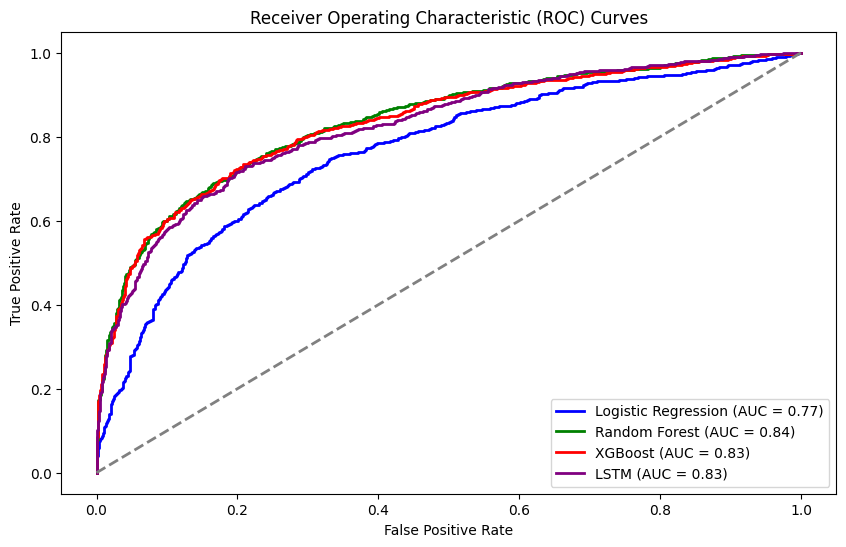

In [193]:
# Plot ROC curves for all models
plt.figure(figsize=(10, 6))
plt.plot(fpr_logreg, tpr_logreg, color='blue', lw=2, label='Logistic Regression (AUC = {:.2f})'.format(roc_auc_logreg))
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label='Random Forest (AUC = {:.2f})'.format(roc_auc_rf))
plt.plot(fpr_xgb, tpr_xgb, color='red', lw=2, label='XGBoost (AUC = {:.2f})'.format(roc_auc_xgb))
plt.plot(fpr_lstm, tpr_lstm, color='purple', lw=2, label='LSTM (AUC = {:.2f})'.format(roc_auc_lstm))

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()